In [1]:
%load_ext autoreload
%autoreload 2

# Digit generation

In [49]:
from sklearn import datasets

pixels, digits = datasets.load_digits(return_X_y=True, as_frame=True)
pixels = pixels.astype('uint8')
pixels.columns = [f"{col.split('_')[1]}-{int(col.split('_')[2])}" for col in pixels.columns]
pixels.head()

/Users/max.halford/projects/hedgehog/hedgehog/bayes_net.py:16: UserWarning: registration of accessor <class 'hedgehog.bayes_net.CDTAccessor'> under name 'cdt' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  class CDTAccessor:


,0-0,0-1,0-2,0-3,0-4,0-5,0-6,0-7,1-0,1-1,...,6-6,6-7,7-0,7-1,7-2,7-3,7-4,7-5,7-6,7-7
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,0,6,13,10,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,0,11,16,10,0,0
2,0,0,0,4,15,12,0,0,0,0,...,5,0,0,0,0,3,11,16,9,0
3,0,0,7,15,13,1,0,0,0,8,...,9,0,0,0,7,13,13,9,0,0
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,0,2,16,4,0,0


Let's look at some of the images.

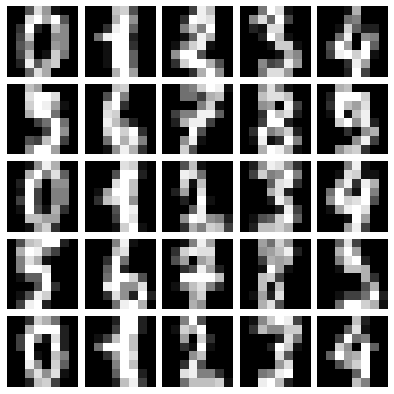

In [32]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

img_shape = (8, 8)

fig = plt.figure(figsize=(7, 7))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=.1)

for i, ax in enumerate(grid):
    img = pixels.iloc[i].values.reshape(img_shape)
    ax.imshow(img, cmap='gray')
    ax.axis('off')

How about if we take a look at 0 digits?

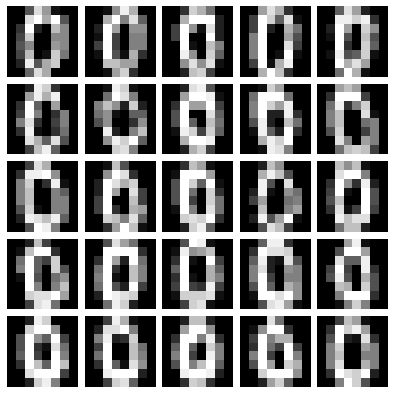

In [33]:
fig = plt.figure(figsize=(7, 7))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=.1)

zeros = pixels[digits == 0]

for i, ax in enumerate(grid):
    img = zeros.iloc[i].values.reshape(img_shape)
    ax.imshow(img, cmap='gray')
    ax.axis('off')

We will define a Bayesian network where each node represents a pixel. Each edge will indicate that the intensity of a pixel is influenced by the intensities of its neighbors.

Let's first define a notion of "neighborhood". Let's say that a pixel's neighbors are the ones that are directly above and to the left of said pixel.

In [50]:
def neighbors(r, c):
    
    top = (r - 1, c)
    left = (r, c - 1)
    
    if r and c:
        return [top, left]
    if r:
        return [top]
    if c:
        return [left]
    return []

neighbors(0, 0)

[]

In [35]:
neighbors(0, 1)

[(0, 0)]

In [36]:
neighbors(1, 0)

[(0, 0)]

In [37]:
neighbors(1, 1)

[(0, 1), (1, 0)]

We can now use this function in order to define our Bayesian network.

In [51]:
import hedgehog

structure = [
    (f'{neighbor[0]}-{neighbor[1]}', f'{r}-{c}')
    for r in range(img_shape[0])
    for c in range(img_shape[1])
    for neighbor in neighbors(r, c)
]

bn = hedgehog.BayesNet(*structure)

We can represent this with Graphviz.

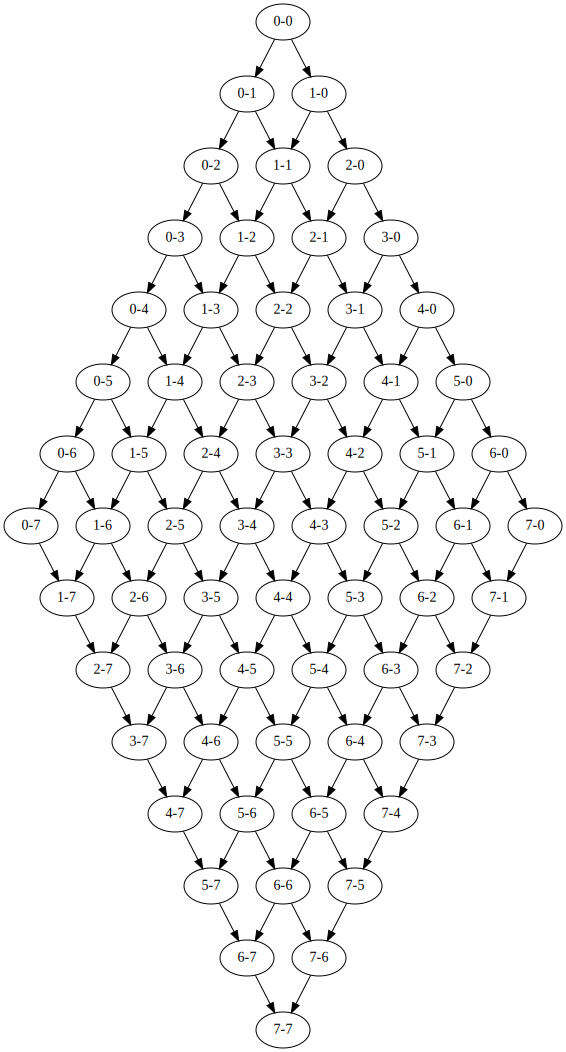

In [52]:
bn.graphviz()

We can also use [Daft](https://docs.daft-pgm.org/en/latest/) and arrange the nodes according to their associated pixel position.

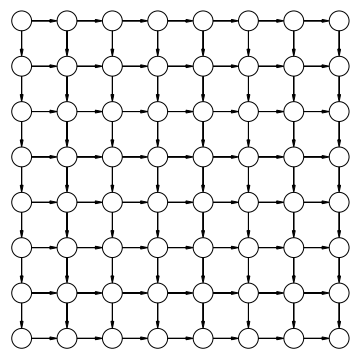

In [54]:
import daft

pgm = daft.PGM(node_unit=.7, grid_unit=1.6, directed=True)

for rc in bn.nodes:
    r, c = rc.split('-')
    pgm.add_node(node=rc, x=int(c), y=img_shape[0] - int(r))

for parent, children in bn.children.items():
    for child in children:
        pgm.add_edge(parent, child)

pgm.render();

To start off with, let's train such a Bayesian network on images that represent the 0 digit.

In [75]:
bn = hedgehog.BayesNet(*structure)
bn = bn.fit(pixels[digits == 0])
sampler = bn._flood_fill_sampling()

KeyError: (15, 1, 16)

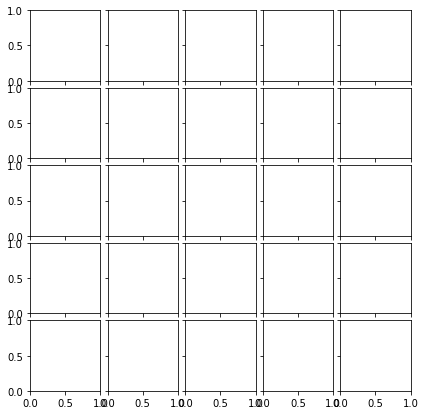

In [76]:
import pandas as pd

fig = plt.figure(figsize=(7, 7))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=.1)

for ax in grid:
    sample = next(sampler)
    img = pd.Series(sample).values.reshape(img_shape)
    ax.imshow(img, cmap='gray')
    ax.axis('off')

We can attempt to empower the Bayesian network by making each pixel also depend on its top-left neighbor, in addition to the top one and the left one.

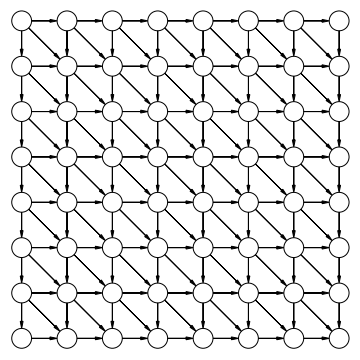

In [63]:
def neighbors(r, c):
    
    top_left = (r - 1, c - 1)
    left = (r, c - 1)
    top = (r - 1, c)
    
    if r and c:
        return [top, left, top_left]
    if r:
        return [top]
    if c:
        return [left]
    return []

bn = hedgehog.BayesNet(*[
    (f'{neighbor[0]}-{neighbor[1]}', f'{r}-{c}')
    for r in range(img_shape[0])
    for c in range(img_shape[1])
    for neighbor in neighbors(r, c)
])

pgm = daft.PGM(node_unit=.7, grid_unit=1.6, directed=True)

for rc in bn.nodes:
    r, c = rc.split('-')
    pgm.add_node(node=rc, x=int(c), y=img_shape[0] - int(r))

for parent, children in bn.children.items():
    for child in children:
        pgm.add_edge(parent, child)

pgm.render();

In [73]:
bn = hedgehog.BayesNet(*structure)
bn = bn.fit(pixels[digits == 0])
sampler = bn._flood_fill_sampling()

StopIteration: 

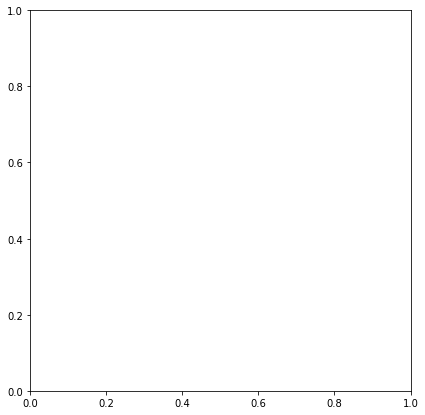

In [68]:
fig = plt.figure(figsize=(7, 7))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 1), axes_pad=.1)

for ax in grid:
    sample = next(sampler)
    img = pd.Series(sample).values.reshape(img_shape)
    ax.imshow(img, cmap='gray')
    ax.axis('off')